In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='svg'
import random
from numba import jit

准备写一系列关于用Monte Carlo模拟的方法来研究betting strategy的文章，这是第一篇，目标是先实现一个下注模拟的系统，在后面再继续加入策略并研究。

前面几篇的绝大部分工作来自于sendex发表在[油管上的视频](https://www.youtube.com/playlist?list=PLQVvvaa0QuDdhOnp-FnVStDsALpYk2hk0)，有科学上网条件的推荐看一下原版的视频，在很多方面讲得更详细。由于这个系列的视频录用时间较早，是基于python2的，与这里的语法有少量不同。

另外原视频内的程序是纯python实现，模拟速度比较慢。我这里为了提速用到了numpy和numba。

首先需要实现一个摇骰子的功能，用简单的random来实现。

In [2]:
@jit(nopython=True)
def win_dice(n=49):
    roll = random.randint(1, 100)
    return bool(roll <= n)

win_dice();  ## warming up the jitted function

测试一下骰子的赢率是不是正确：

In [3]:
wins = 0
losses = 0
for _ in range(100000):
    if win_dice():
        wins += 1
    else:
        losses += 1
print('Win rate:', wins/100000, '\tLoss rate:', losses/100000)

Win rate: 0.4892 	Loss rate: 0.5108


考虑到随机本身的波动，基本上可以认为是正确的。

接下来实现一个无脑下注的系统，也就是完全不讲究策略，纯粹参与游戏。

In [4]:
def brainless_bettor(funds, init_wager, wager_count, plot=True, marker='none'):
    balance = funds
    wager = init_wager
    vY = -funds * np.ones(wager_count) / 10

    for i in range(wager_count):
        if win_dice():
            balance += wager
        else:
            balance -= wager
        vY[i] = balance
        if balance <= 0:
            break

    if plot:
        plt.plot(vY, lw=0.5, marker=marker)
    return balance

逻辑应该非常显然了，大致解释一下：模拟的 brainless bettor 接受三个参数，分别是初始的资金、最初的赌注和下注的次数。函数体中，balance 记录当前的资金量，wager 记录当前赌注，vY 记录资金量的变化（这里用 numpy 的 ndarray，原因是后面希望把这个函数本身也 JIT 掉，在模拟的次数多的时候很有必要）。

尝试跑一下，看看结果差不多是不是正确的。

9400

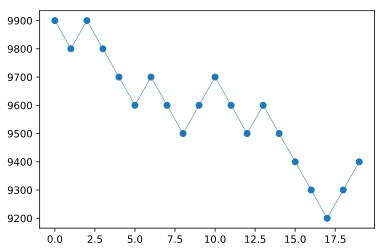

In [5]:
brainless_bettor(10000, 100, 20, marker='o')

看起来没有问题，因为是单纯的无脑参与，而且没有在中间改变赌注大小，每一次资金量增加和减少的量都是固定的。

接下来先做一个简单的蒙特卡洛：模拟三十个这样的无脑赌博，初始资金为一万，每次赌一百，下注两千次（如果输比赢多一百次的话就会破产，无法继续玩下去），看看资金量变化的曲线。

在这之前，需要把前面的下注函数作一定的修改，默认不需要画出资金量的曲线，并且用 numba 的 jit 来加速计算。

In [6]:
@jit
def brainless_bettor(funds, init_wager, wager_count, plot=False):
    balance = funds
    wager = init_wager
    vY = -funds * np.ones(wager_count) / 10

    for i in range(wager_count):
        if win_dice():
            balance += wager
        else:
            balance -= wager
        vY[i] = balance
        if balance <= 0:
            break

    if plot:
        plt.plot(vY, lw=0.5)
    return balance

brainless_bettor(100, 10, 10)  ## warming up

120

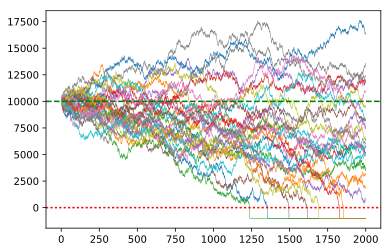

In [7]:
for _ in range(30):
    brainless_bettor(10000, 100, 2000, plot=True)
plt.axhline(y=0, ls='dotted', c='r')
plt.axhline(y=10000, ls='dashed', c='g')

基本与预期的一致，平均来看，走势基本是下降的，但有相当比例实现了盈利，有3个全部输光。

接下来比较关心的是用更大数量的模拟做统计分析，这时候就不再需要把资金曲线画出来了，只关心最后的结果。

In [8]:
n_sim = int(1e5)
res = np.ones(n_sim, dtype='i8')
for i in range(n_sim):
    balance = brainless_bettor(10000, 100, 3000)
    res[i] = balance
print('Out of {} games, mean is {}, std is {:.3f}'.format(n_sim, res.mean(), res.std()))

Out of 100000 games, mean is 4576.786, std is 4508.475


(array([  3.32900000e+04,   1.51300000e+03,   1.53800000e+03,
          2.83700000e+03,   3.29800000e+03,   2.46300000e+03,
          3.77600000e+03,   2.63100000e+03,   4.17500000e+03,
          4.16600000e+03,   2.72300000e+03,   4.04900000e+03,
          3.98800000e+03,   2.42100000e+03,   3.47300000e+03,
          2.18100000e+03,   3.12400000e+03,   2.80300000e+03,
          1.62400000e+03,   2.33300000e+03,   1.97600000e+03,
          1.19300000e+03,   1.54400000e+03,   9.65000000e+02,
          1.16100000e+03,   1.00600000e+03,   5.53000000e+02,
          7.07000000e+02,   3.96000000e+02,   4.92000000e+02,
          4.11000000e+02,   2.05000000e+02,   2.44000000e+02,
          2.04000000e+02,   1.07000000e+02,   1.24000000e+02,
          5.40000000e+01,   7.20000000e+01,   6.30000000e+01,
          2.10000000e+01,   3.10000000e+01,   1.60000000e+01,
          1.10000000e+01,   1.20000000e+01,   1.00000000e+01,
          3.00000000e+00,   5.00000000e+00,   0.00000000e+00,
        

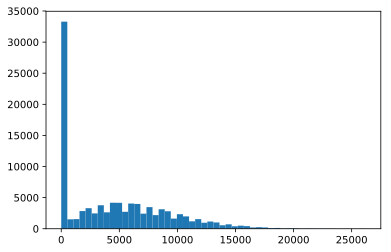

In [9]:
plt.hist(res, bins=50)

看起来由于下注的次数太多，太大比例的人已经破产了，没有什么有趣的信息，把下注次数调小一点看看：

In [10]:
n_sim = int(1e5)
res = np.ones(n_sim, dtype='i8')
for i in range(n_sim):
    balance = brainless_bettor(10000, 100, 1000)
    res[i] = balance
print('Out of {} games, mean is {}, std is {:.3f}'.format(n_sim, res.mean(), res.std()))

Out of 100000 games, mean is 8007.43, std is 3159.070


(array([  1.04400000e+03,   7.90000000e+01,   1.07000000e+02,
          1.55000000e+02,   2.15000000e+02,   2.22000000e+02,
          2.58000000e+02,   3.19000000e+02,   3.64000000e+02,
          4.37000000e+02,   4.50000000e+02,   5.02000000e+02,
          1.20400000e+03,   7.46000000e+02,   8.00000000e+02,
          8.89000000e+02,   9.31000000e+02,   1.03700000e+03,
          1.13600000e+03,   1.21700000e+03,   1.25400000e+03,
          1.43200000e+03,   1.50800000e+03,   1.69100000e+03,
          1.68500000e+03,   3.75800000e+03,   1.87000000e+03,
          2.07300000e+03,   2.12200000e+03,   2.15100000e+03,
          2.37600000e+03,   2.34100000e+03,   2.29900000e+03,
          2.45100000e+03,   2.44900000e+03,   2.60500000e+03,
          2.50300000e+03,   4.78400000e+03,   2.56900000e+03,
          2.49100000e+03,   2.40000000e+03,   2.43300000e+03,
          2.42000000e+03,   2.34500000e+03,   2.25800000e+03,
          2.16700000e+03,   2.12900000e+03,   1.97200000e+03,
        

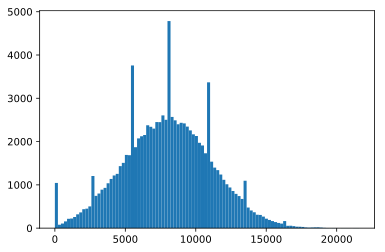

In [11]:
plt.hist(res, bins=100)

很明显的一点是，下注次数少的时候，输光的人大幅减小，而反倒有相当比例的人实现了盈利。

接下来感兴趣的是，如果给定初始资金和下注金额，不同的下注次数分别有什么影响。

In [12]:
wager_counts = [20, 50, 100, 1000, 2000, 5000]
for wager_count in wager_counts:
    res = np.ones(100000, dtype='i8')
    for i in range(100000):
        balance = brainless_bettor(10000, 100, wager_count)
        res[i] = balance
    print('Wager count is {}'.format(wager_count))
    print('Broke percentage: {:.1f}%'.format(len(res[res<=0])/100000 * 100))
    print('Profit percentage: {:.1f}%'.format(len(res[res>10000])/100000 * 100))
    print('If profit, average profit is: {:.1f}'.format(np.mean(res[res>10000]) - 10000))
    print('If nonprofit, average loss is: {:.1f}\n'.format(10000 - np.mean(res[res<=10000])))

Wager count is 20
Broke percentage: 0.0%
Profit percentage: 37.8%
If profit, average profit is: 415.2
If nonprofit, average loss is: 316.3

Wager count is 50
Broke percentage: 0.0%
Profit percentage: 38.7%
If profit, average profit is: 599.3
If nonprofit, average loss is: 543.7

Wager count is 100
Broke percentage: 0.0%
Profit percentage: 38.4%
If profit, average profit is: 800.5
If nonprofit, average loss is: 818.7

Wager count is 1000
Broke percentage: 0.9%
Profit percentage: 25.2%
If profit, average profit is: 2000.6
If nonprofit, average loss is: 3343.5

Wager count is 2000
Broke percentage: 13.9%
Profit percentage: 17.9%
If profit, average profit is: 2513.4
If nonprofit, average loss is: 5269.9

Wager count is 5000
Broke percentage: 62.6%
Profit percentage: 7.6%
If profit, average profit is: 3280.0
If nonprofit, average loss is: 8323.6

